<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/Nougat/Inference_with_Nougat_to_read_scientific_PDFs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference with Nougat to read scientific PDFs

In this notebook, we'll perform inference with Nougat, a Donut model trained by Meta AI to transcribe scientific PDFs into a common Markdown format. Docs for Nougat can be found [here](https://huggingface.co/docs/transformers/main/en/model_doc/nougat).

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/nougat_architecture.jpg"
alt="drawing" width="600"/>

<small> Nougat high-level overview. Taken from the <a href="https://arxiv.org/abs/2308.13418">original paper</a>. </small>

## Set-up environment

Let's start by installing 🤗 Transformers and [pymupdf](https://github.com/pymupdf/PyMuPDF), a library which we can use to read PDFs as images. We install Transformers from source here since the model is brand new at the time of writing.

We also install Levenshtein and NLTK as those are required for postprocessing.

In [1]:
!pip install -q pymupdf python-Levenshtein nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 82.2 MB/s eta 0:00:00


In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.7 MB/s eta 0:00:00


## Load model and processor

Next, we instantiate the model and its processor from the hub.

In [3]:
from transformers import AutoProcessor, VisionEncoderDecoderModel
import torch

processor = AutoProcessor.from_pretrained("facebook/nougat-small")
model = VisionEncoderDecoderModel.from_pretrained("facebook/nougat-small")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


We also move the model to the GPU if it's available. I used "capture" below to avoid printing the entire model.

In [4]:
%%capture
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

## Load PDF

Below we load a sample PDF, and then use the fitz module to turn it into a list of Pillow images (one for each page).

In [5]:
from huggingface_hub import hf_hub_download

filepath = hf_hub_download(repo_id="ysharma/nougat", filename="input/nougat.pdf", repo_type="space")
print(filepath)

/root/.cache/huggingface/hub/spaces--ysharma--nougat/snapshots/a6d4607a70fcab8ea3e8bda96a2686943b81e7d8/input/nougat.pdf


In [6]:
from typing import Optional, List
import io
import fitz
from pathlib import Path

def rasterize_paper(
    pdf: Path,
    outpath: Optional[Path] = None,
    dpi: int = 96,
    return_pil=False,
    pages=None,
) -> Optional[List[io.BytesIO]]:
    """
    Rasterize a PDF file to PNG images.

    Args:
        pdf (Path): The path to the PDF file.
        outpath (Optional[Path], optional): The output directory. If None, the PIL images will be returned instead. Defaults to None.
        dpi (int, optional): The output DPI. Defaults to 96.
        return_pil (bool, optional): Whether to return the PIL images instead of writing them to disk. Defaults to False.
        pages (Optional[List[int]], optional): The pages to rasterize. If None, all pages will be rasterized. Defaults to None.

    Returns:
        Optional[List[io.BytesIO]]: The PIL images if `return_pil` is True, otherwise None.
    """

    pillow_images = []
    if outpath is None:
        return_pil = True
    try:
        if isinstance(pdf, (str, Path)):
            pdf = fitz.open(pdf)
        if pages is None:
            pages = range(len(pdf))
        for i in pages:
            page_bytes: bytes = pdf[i].get_pixmap(dpi=dpi).pil_tobytes(format="PNG")
            if return_pil:
                pillow_images.append(io.BytesIO(page_bytes))
            else:
                with (outpath / ("%02d.png" % (i + 1))).open("wb") as f:
                    f.write(page_bytes)
    except Exception:
        pass
    if return_pil:
        return pillow_images

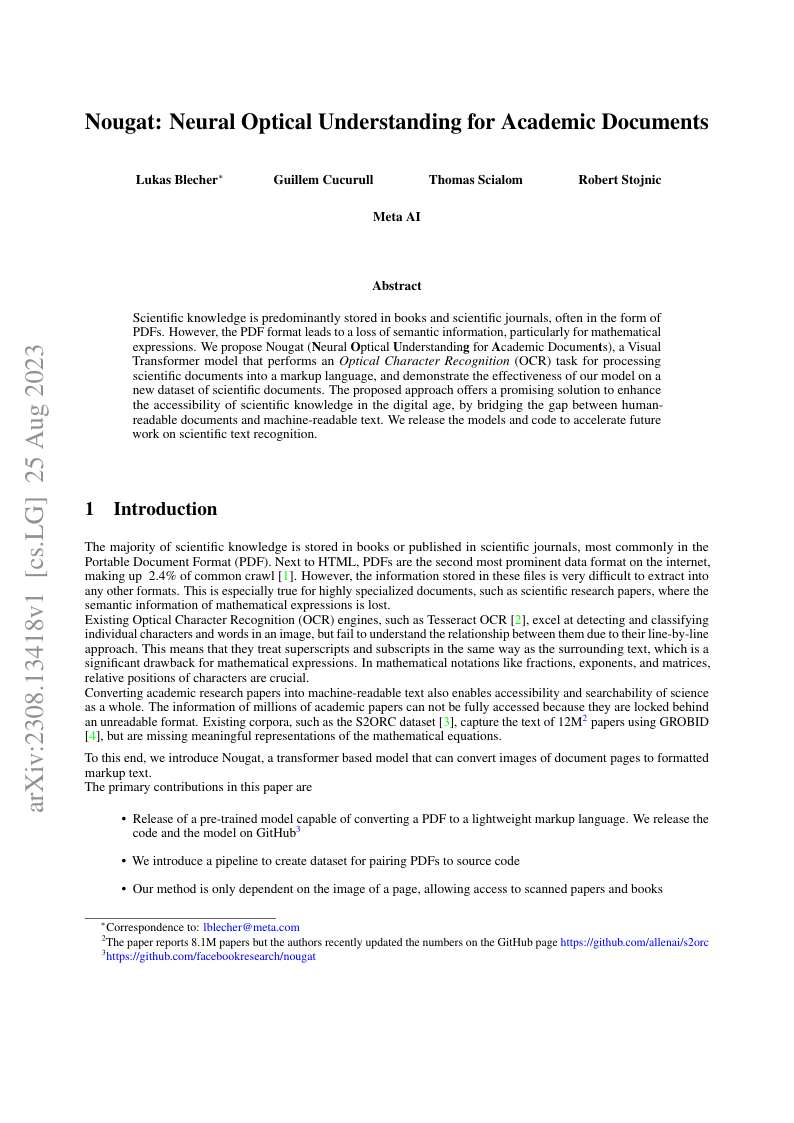

In [7]:
from PIL import Image

images = rasterize_paper(pdf=filepath, return_pil=True)
image = Image.open(images[0])
image

## Generate transcription

Next, we let the model autoregressively generate the text appearning in the PDF. This is a lot faster on GPU than on CPU.

The authors did define some custom `StoppingCriteria`(which determine when the model should stop generating), so we're going to use them here as well.

In [8]:
# prepare image for the model
pixel_values = processor(images=image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 896, 672])


In [11]:
from transformers import StoppingCriteria, StoppingCriteriaList
from collections import defaultdict

class RunningVarTorch:
    def __init__(self, L=15, norm=False):
        self.values = None
        self.L = L
        self.norm = norm

    def push(self, x: torch.Tensor):
        assert x.dim() == 1
        if self.values is None:
            self.values = x[:, None]
        elif self.values.shape[1] < self.L:
            self.values = torch.cat((self.values, x[:, None]), 1)
        else:
            self.values = torch.cat((self.values[:, 1:], x[:, None]), 1)

    def variance(self):
        if self.values is None:
            return
        if self.norm:
            return torch.var(self.values, 1) / self.values.shape[1]
        else:
            return torch.var(self.values, 1)


class StoppingCriteriaScores(StoppingCriteria):
    def __init__(self, threshold: float = 0.015, window_size: int = 200):
        super().__init__()
        self.threshold = threshold
        self.vars = RunningVarTorch(norm=True)
        self.varvars = RunningVarTorch(L=window_size)
        self.stop_inds = defaultdict(int)
        self.stopped = defaultdict(bool)
        self.size = 0
        self.window_size = window_size

    @torch.no_grad()
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        last_scores = scores[-1]
        self.vars.push(last_scores.max(1)[0].float().cpu())
        self.varvars.push(self.vars.variance())
        self.size += 1
        if self.size < self.window_size:
            return False

        varvar = self.varvars.variance()
        for b in range(len(last_scores)):
            if varvar[b] < self.threshold:
                if self.stop_inds[b] > 0 and not self.stopped[b]:
                    self.stopped[b] = self.stop_inds[b] >= self.size
                else:
                    self.stop_inds[b] = int(
                        min(max(self.size, 1) * 1.15 + 150 + self.window_size, 4095)
                    )
            else:
                self.stop_inds[b] = 0
                self.stopped[b] = False
        return all(self.stopped.values()) and len(self.stopped) > 0

In [20]:
# autoregressively generate tokens, with custom stopping criteria (as defined by the Nougat authors)
outputs = model.generate(pixel_values.to(device),
                          min_length=1,
                          max_length=3584,
                          bad_words_ids=[[processor.tokenizer.unk_token_id]],
                          return_dict_in_generate=True,
                          output_scores=True,
                          stopping_criteria=StoppingCriteriaList([StoppingCriteriaScores()]),
)

## Postprocess

Finally we decode the generated IDs back to text and postprocess the generation.

In [22]:
generated = processor.batch_decode(outputs[0], skip_special_tokens=True)[0]
generated = processor.post_process_generation(generated, fix_markdown=False)
print(generated)



# Nougat: Neural Optical Understanding for Academic Documents

 Lukas Blecher

Correspondence to: lblecher@meta.com

Guillem Cucurull

Thomas Scialom

Robert Stojnic

Meta AI

The paper reports 8.1M papers but the authors recently updated the numbers on the GitHub page https://github.com/allenai/s2orc

###### Abstract

Scientific knowledge is predominantly stored in books and scientific journals, often in the form of PDFs. However, the PDF format leads to a loss of semantic information, particularly for mathematical expressions. We propose Nougat (**N**eural **O**ptical **U**nderstanding for **A**cademic Documents), a Visual Transformer model that performs an _Optical Character Recognition_ (OCR) task for processing scientific documents into a markup language, and demonstrate the effectiveness of our model on a new dataset of scientific documents. The proposed approach offers a promising solution to enhance the accessibility of scientific knowledge in the digital age, by bridging the